In [1]:
# imports

## allow interaction with the plots
%matplotlib widget

%load_ext autoreload
%autoreload 2

# add the main directory reference and import 'imports.py'
import sys
import os

if ".." not in sys.path:
    sys.path.insert(0, "..")
from tnibs.user import *

logger = logging.getLogger()
logger.setLevel(level=logging.WARN)

__builtins__.verbosity = 4
# Set the HF_HOME environment variable
os.environ["HF_HOME"] = "/run/media/HUNK/DATASETS/HF"


In [9]:
from eval.play import ChessGame
from lib.chess import chess_move_labels as le
from models.nanoRWKV import *
from models.nanoGPT import *


rwkv_model = RWKV(GPTConfig(vocab_size=len(le.classes_), bias=True, seq_len=140))
rwkv_model.load_from_pth(
    # "out/RWKV__seq_len=140__vocab_size=7797__n_layer=12__n_head=12__n_embd=768__dropout=0.0__bias=True__lr=0.005__weight_decay=0.01__epoch=38-88.pth"
    "out/RWKV__seq_len=140__vocab_size=7797__n_layer=12__n_head=12__n_embd=768__dropout=0.0__bias=True__ignore_index=0__lr=0.005__weight_decay=0.01__epoch=240-240.pth"
)
rwkv_model.to(device)


gpt_model = GPT(GPTConfig(vocab_size=len(le.classes_), bias=True, seq_len=140))
gpt_model.load_from_pth(
    "out/GPT__seq_len=140__vocab_size=7797__n_layer=12__n_head=12__n_embd=768__dropout=0.0__bias=True__lr=0.01__weight_decay=0.01__epoch=133-226.pth"
)
gpt_model.to(device)

# check labelling
idx = torch.tensor(le.transform(["Ng1f3"])).view(1, -1).to(device)
print(idx)
result = rwkv_model.generate(idx, 5).cpu()
le.inverse_transform(result.flatten())


number of parameters: 91.13M


/ARCHIVE/Personal/2186474940/lib/modules.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pth_path)


number of parameters: 91.04M
tensor([[1256]], device='cuda:0')


array(['Ng1f3', 'ng8f6', 'Pb2b3', 'pg7g6', 'Bc1b2', 'bf8g7'], dtype='<U6')

In [10]:
game = ChessGame(gpt_model)
game.play()

Invalid move! Please try again.
Resigning...


('VARIANT_WIN', 1)

In [4]:
from tnibs.metric.plot import *
from lib.chess import *


def test_model(model_1, model_2, iters):
    game = ChessGame(model_1, p1_model=model_2, draw_board="")
    results = []

    for _ in range(iters):
        outcome = game.play()
        # dbg(game.board)
        results.append((outcome, game.board.copy()))

    return results


def display_stats(results):
    outcomes = Counter([x[0] for x in results])
    game_lengths = [len(x[1].move_stack) for x in results if x[0][0] != "VARIANT_WIN"]
    resign_game_lengths = [
        len(x[1].move_stack) for x in results if x[0][0] == "VARIANT_WIN"
    ]
    losses = iters_to_losses([x[1].move_stack for x in results])
    mean_losses = transverse_mean(losses)

    # plotting
    plot_bar(outcomes, stack_label="winner")
    plot_points(
        game_lengths,
        resign_game_lengths,
        set_labels=("completed game lengths", "terminated game lengths"),
    )
    plot_points(mean_losses, kind="line")

    return mean_losses


def transverse_mean(arrays, length=100):
    totals = np.zeros(length)
    counts = np.zeros(length)

    for arr in arrays:
        for i in range(min(len(arr), length)):
            totals[i] += arr[i]
            counts[i] += 1

    mean_losses = totals / counts
    return mean_losses


def iters_to_losses(move_stacks, num_workers=24):
    results = []

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [
            executor.submit(
                iter_to_evals, move_stack, True, uci_path="/usr/bin/stockfish", time=0.2
            )
            for move_stack in move_stacks
        ]

        for future in as_completed(futures):
            results.append(future.result()[1])

    return results


All attempts failed. Resigning...
Generation of multiple legal moves failed. Resigning...
Generation of multiple legal moves failed. Resigning...
Generation of multiple legal moves failed. Resigning...
Generation of multiple legal moves failed. Resigning...
All attempts failed. Resigning...
Generation of multiple legal moves failed. Resigning...
Generation of multiple legal moves failed. Resigning...
All attempts failed. Resigning...
Generation of multiple legal moves failed. Resigning...
Generation of multiple legal moves failed. Resigning...
Generation of multiple legal moves failed. Resigning...
All attempts failed. Resigning...
Generation of multiple legal moves failed. Resigning...
Generation of multiple legal moves failed. Resigning...
Generation of multiple legal moves failed. Resigning...
Generation of multiple legal moves failed. Resigning...
All attempts failed. Resigning...
Generation of multiple legal moves failed. Resigning...
All attempts failed. Resigning...
All attempts

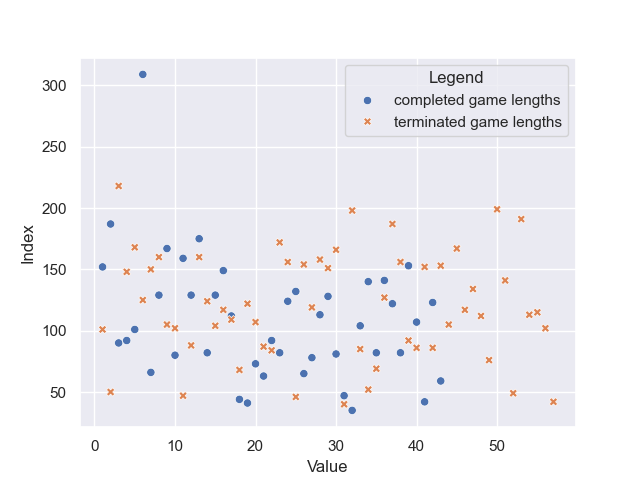

In [5]:
results = test_model(rwkv_model, rwkv_model, 100)
losses = display_stats(results)

All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts f

/tmp/ipykernel_1393383/1532199822.py:47: RuntimeWarning: invalid value encountered in divide
  mean_losses = totals / counts


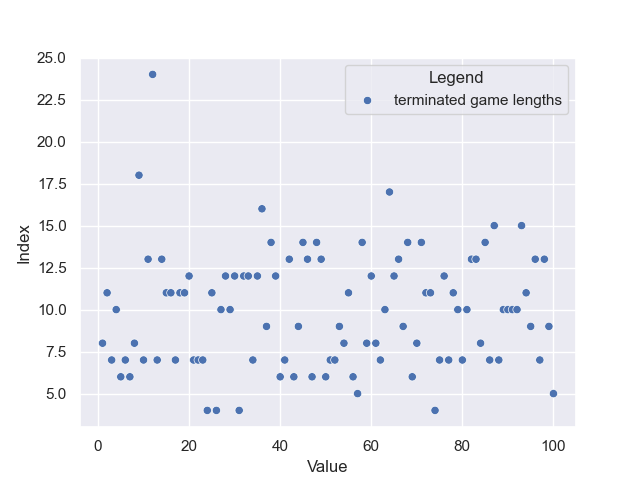

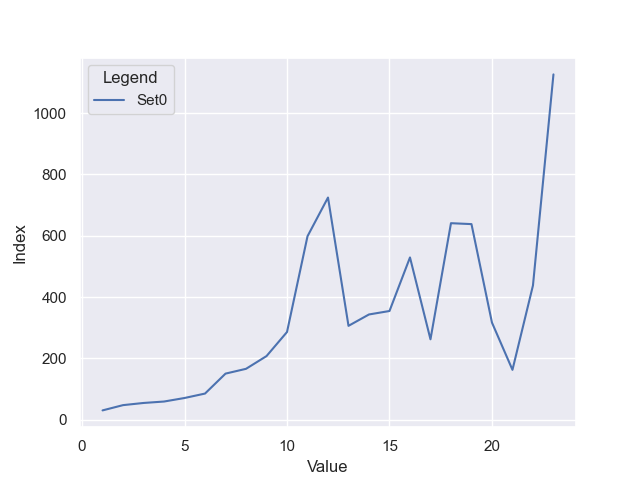

In [8]:
results = test_model(gpt_model, gpt_model, 100)
losses = display_stats(results)


All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
Generation of multiple legal moves failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
Generation of multiple legal moves failed. Resigning...
All attempts failed. Resigning...
All attempts failed. Resigning...
All 

/tmp/ipykernel_1393383/1532199822.py:47: RuntimeWarning: invalid value encountered in divide
  mean_losses = totals / counts


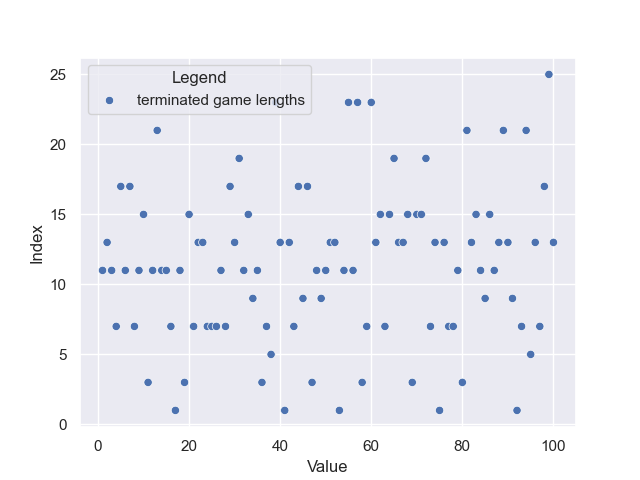

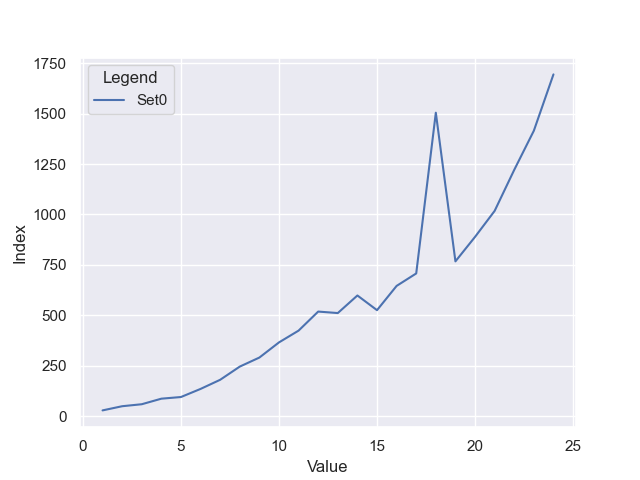

In [9]:
results = test_model(rwkv_model, gpt_model, 100)
losses = display_stats(results)
